In [294]:
import numpy as np
from sklearn.svm import SVR
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing


In [334]:
batting_data_path = 'bsb_ref.csv'
# INFO:
# 101,332 Players with up to 20 features each (exluding year, including team)
# if metric not reported for player, set to 0.0 by default

df_original = pd.read_csv(batting_data_path)
df = df_original.fillna(df.mean()) # fixing this could really help with results potentially
df_recent_players = df[df.year_ID >= 1975] 
df_just_hitters = df_recent_players[df_recent_players.pitcher == 'N']

# for the player specific SVR, I will choose players with at least 20 years of activity. 
# the data will be split as follows:
# x_train: year 0-5 data. the shape is: (num_samples, num_features) -> (6, num_features)
# y_train: year 6-12 OPS_plus. the shape is: (num_samples, 1) -> (6,1)

# x_test: year 13-14 data
# y_test: year 14-15 data
players = list(set(df_probably_not_pitchers['name_common'])) # just a set of all players

players_with_more_than_20_years = [player for player in players if len(df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]) >= 16]
print(players_with_more_than_20_years)

['Kirk Gibson', 'Stan Javier', 'Tim Raines', 'Willie Randolph', 'Carlton Fisk', 'Harold Baines', 'Jose Canseco', 'Jose Guillen', 'Dave Collins', 'Brady Anderson', 'Dave Martinez', 'Luis Castillo', 'Jose Reyes', 'Adrian Beltre', 'Aramis Ramirez', 'Alex Rodriguez', 'Mark Teixeira', 'Brian Giles', 'Edgar Martinez', 'Devon White', 'Edwin Encarnacion', 'Matt Stairs', 'Lenny Harris', 'Raul Ibanez', 'Dave Magadan', 'Russell Branyan', 'Terry Pendleton', 'Mike Cameron', 'Carlos Baerga', 'Jeff Reed', 'Jay Bell', 'Tino Martinez', 'Jim Edmonds', 'Kenny Lofton', 'Torii Hunter', 'Craig Counsell', 'Moises Alou', 'Jerry Hairston', 'Bernie Williams', 'Coco Crisp', 'Jeff Kent', 'Damion Easley', 'Jose Cruz', 'Brian Downing', 'Delino DeShields', 'Barry Bonds', 'Garry Templeton', 'Tony Armas', 'Derek Jeter', 'Robin Ventura', 'John Olerud', 'Jeff Conine', 'Luis Gonzalez', 'Jim Gantner', 'Benito Santiago', 'David Ortiz', 'Eric Young Sr.', 'Reggie Sanders', 'Shawon Dunston', 'Mike Sweeney', 'Lance Berkman', '

In [335]:
def prepare_test_train(player_x_data, player_y_data):
    i_0, i_1, i_2, i_3 = 6, 12, 13, 14 # hardcoded for now. these are just the ranges described above
    x_train = player_x_data[:i_0,:]
    y_train = player_y_data[i_0:i_1]
    x_test = player_x_data[i_1:i_2]
    y_test = player_y_data[i_2: i_3]
    return (x_train, y_train, x_test, y_test)

In [406]:
def run_svr(data_tuple):
    x_train, y_train, x_test, y_test = data_tuple
    parameters = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,150,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e8],
    "epsilon": [0.1, 0.01]
    }

    svr = GridSearchCV(SVR(), parameters, cv=3)
    svr.fit(x_train, y_train.ravel())

    y_svr_pred = svr.predict(x_test)
    print("Actual OPS_plus %.3f" % y_test.ravel())
    print("Predicted OPS_plus %.3f" % y_svr_pred)

    print('Score: %.3f' % svr.score(x_train, y_train))
    print("Mean squared error: %.3f" % mean_squared_error(y_test, y_svr_pred))
    print('Mean Absolute error: %.3f' % mean_absolute_error(y_test, y_svr_pred))
    print('Variance score: %.3f' % r2_score(y_test, y_svr_pred))
    print()
    
    return (y_test, y_svr_pred, mean_absolute_error(y_test, y_svr_pred))


    

In [358]:
def prepare_rows(player_rows):
    player_x_data =player_rows[['age', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field',
                                       'WAA', 'WAA_off', 'WAA_def', 'OPS_plus']].values
    player_y_data = player_rows[['OPS_plus']].values
    return (player_x_data, player_y_data)
    

In [360]:
from collections import defaultdict
loss_dict = defaultdict(float)
for player in players_with_more_than_20_years:
    print(player)
    player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]
    data = prepare_rows(player_rows)
    data_tuple = prepare_test_train(data[0], data[1])
    loss_dict[player] = run_svr(data_tuple)

Kirk Gibson
Actual OPS_plus 106.700
Predicted OPS_plus 94.676
Score: 1.000
Mean squared error: 144.577
Mean Absolute error: 12.024
Variance score: 0.000

Stan Javier
Actual OPS_plus 105.840
Predicted OPS_plus 104.020
Score: 0.315
Mean squared error: 3.311
Mean Absolute error: 1.820
Variance score: 0.000

Tim Raines
Actual OPS_plus 101.807
Predicted OPS_plus 140.950
Score: 0.494
Mean squared error: 1532.227
Mean Absolute error: 39.144
Variance score: 0.000

Willie Randolph
Actual OPS_plus 76.638
Predicted OPS_plus 102.102
Score: 0.851
Mean squared error: 648.445
Mean Absolute error: 25.465
Variance score: 0.000

Carlton Fisk
Actual OPS_plus 154.880
Predicted OPS_plus 98.558
Score: 0.335
Mean squared error: 3172.150
Mean Absolute error: 56.322
Variance score: 0.000

Harold Baines
Actual OPS_plus 142.787
Predicted OPS_plus 114.780
Score: 0.016
Mean squared error: 784.445
Mean Absolute error: 28.008
Variance score: 0.000

Jose Canseco
Actual OPS_plus 106.491
Predicted OPS_plus 138.299
Scor

Actual OPS_plus 83.120
Predicted OPS_plus 83.809
Score: 0.114
Mean squared error: 0.474
Mean Absolute error: 0.689
Variance score: 0.000

Benito Santiago
Actual OPS_plus 78.560
Predicted OPS_plus 118.287
Score: 0.792
Mean squared error: 1578.266
Mean Absolute error: 39.727
Variance score: 0.000

David Ortiz
Actual OPS_plus 153.589
Predicted OPS_plus 151.346
Score: -0.038
Mean squared error: 5.030
Mean Absolute error: 2.243
Variance score: 0.000

Eric Young Sr.
Actual OPS_plus 38.829
Predicted OPS_plus 92.110
Score: 0.182
Mean squared error: 2838.876
Mean Absolute error: 53.281
Variance score: 0.000

Reggie Sanders
Actual OPS_plus 127.106
Predicted OPS_plus 94.997
Score: 0.627
Mean squared error: 1030.956
Mean Absolute error: 32.109
Variance score: 0.000

Shawon Dunston
Actual OPS_plus 69.166
Predicted OPS_plus 95.303
Score: 1.000
Mean squared error: 683.151
Mean Absolute error: 26.137
Variance score: 0.000

Mike Sweeney
Actual OPS_plus 107.912
Predicted OPS_plus 118.681
Score: 0.073
Me

Actual OPS_plus 159.272
Predicted OPS_plus 137.813
Score: -0.018
Mean squared error: 460.475
Mean Absolute error: 21.459
Variance score: 0.000

Glenallen Hill
Actual OPS_plus 134.304
Predicted OPS_plus 111.118
Score: 0.108
Mean squared error: 537.589
Mean Absolute error: 23.186
Variance score: 0.000

Joe Carter
Actual OPS_plus 95.053
Predicted OPS_plus 112.172
Score: 0.087
Mean squared error: 293.076
Mean Absolute error: 17.119
Variance score: 0.000

Johnny Damon
Actual OPS_plus 118.472
Predicted OPS_plus 105.884
Score: 0.820
Mean squared error: 158.450
Mean Absolute error: 12.588
Variance score: 0.000

Tony Fernandez
Actual OPS_plus 91.141
Predicted OPS_plus 100.004
Score: -0.008
Mean squared error: 78.545
Mean Absolute error: 8.863
Variance score: 0.000

Cal Ripken Jr.
Actual OPS_plus 91.178
Predicted OPS_plus 157.593
Score: 0.007
Mean squared error: 4411.008
Mean Absolute error: 66.415
Variance score: 0.000

Marquis Grissom
Actual OPS_plus 122.725
Predicted OPS_plus 81.616
Score: 0.

Actual OPS_plus 99.012
Predicted OPS_plus 136.971
Score: 0.920
Mean squared error: 1440.908
Mean Absolute error: 37.959
Variance score: 0.000

Bob Boone
Actual OPS_plus 110.263
Predicted OPS_plus 67.925
Score: 0.273
Mean squared error: 1792.478
Mean Absolute error: 42.338
Variance score: 0.000

Manny Ramirez
Actual OPS_plus 165.093
Predicted OPS_plus 169.737
Score: 1.000
Mean squared error: 21.571
Mean Absolute error: 4.644
Variance score: 0.000

Brent Mayne
Actual OPS_plus 67.506
Predicted OPS_plus 79.903
Score: 0.887
Mean squared error: 153.665
Mean Absolute error: 12.396
Variance score: 0.000

Jimmy Rollins
Actual OPS_plus 85.522
Predicted OPS_plus 98.638
Score: 0.846
Mean squared error: 172.023
Mean Absolute error: 13.116
Variance score: 0.000

Steve Finley
Actual OPS_plus 117.100
Predicted OPS_plus 115.976
Score: 0.623
Mean squared error: 1.264
Mean Absolute error: 1.124
Variance score: 0.000

B.J. Surhoff
Actual OPS_plus 93.097
Predicted OPS_plus 107.242
Score: 0.152
Mean squared

In [429]:
from operator import itemgetter

# sort dictionary by lowest loss
sorted_loss = [(k, loss_dict[k]) for k in sorted(loss_dict.keys(), key=lambda x: loss_dict[x][-1])]

# top 10 lowest loss:
best_ten = sorted_loss[:10]

# top 10 worst loss:
worst_ten = sorted_loss[-10:]
best_ten

[('Tony Phillips',
  (array([[122.9453]]), array([123.10070759]), 0.1554075932110095)),
 ('Omar Vizquel',
  (array([[103.761]]), array([103.57832212]), 0.1826778785459311)),
 ('Jerry Hairston',
  (array([[93.3355]]), array([93.56065206]), 0.22515206055091141)),
 ('Jeff Conine',
  (array([[102.6726]]), array([102.91236256]), 0.23976256115831518)),
 ('Cliff Floyd',
  (array([[126.6255]]), array([126.90269077]), 0.2771907745251525)),
 ('Jose Vizcaino',
  (array([[68.9028]]), array([69.18905]), 0.28625000000000966)),
 ('Dave Martinez',
  (array([[71.6035]]), array([72.07107347]), 0.46757346743088135)),
 ('Jim Gantner', (array([[83.12]]), array([83.80854197]), 0.6885419697994593)),
 ('Robin Yount', (array([[131.8846]]), array([132.6876]), 0.8029999999999973)),
 ('Dwight Evans',
  (array([[136.1915]]), array([135.30341998]), 0.8880800218688307))]

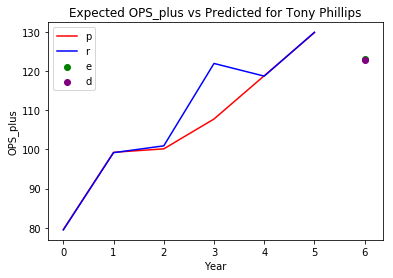

In [441]:
# analysis on best 10:
player = 'Tony Phillips'
player_rows = df_probably_not_pitchers[df_probably_not_pitchers['name_common'] == player]
data = prepare_rows(player_rows)
data_tuple = prepare_test_train(data[0], data[1])
x_train, y_train, x_test, y_test = data_tuple

parameters = {
    "kernel": ["rbf"],
    "C": [1,10,10,100,150,1000],
    "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e8],
    "epsilon": [0.1, 0.01]
    }

svr = GridSearchCV(SVR(), parameters, cv=3)
svr.fit(x_train, y_train.ravel())
y_svr_pred = svr.predict(x_test)


X_grid = np.arange(min(x_train[:,:1]), max(x_train[:,:1]), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))

plt.plot(svr.predict(x_train), color = 'red')
plt.plot(y_train, color = 'blue')


# plt.plot(y_train,  svr.predict(x_train), color = 'blue')
plt.scatter(len(y_train), y_svr_pred, color = 'green')
plt.scatter(len(y_train), y_test, color = 'purple')
plt.legend('predicted')




plt.title('Expected OPS_plus vs Predicted for %s' % player)
plt.xlabel('Year')
plt.ylabel('OPS_plus')
plt.show()
